# Clone Indonlu
Kita akan mengcopy github dari indonlu untuk menggunakan dataset NLP. Jadi dengan `!git clone` kita menarik semua file yang berada di githubnya.

In [1]:
!git clone https://github.com/indobenchmark/indonlu

fatal: destination path 'indonlu' already exists and is not an empty directory.


# Import Library

Ada beberapa library yang akan kita gunakan,
* pandas : untuk membaca file csv sekaligus manipulasi dataframe.
* joblib : untuk save model.
* wordcloud : melihat kata-kata yang sering muncul dengan visual.
* TfidfVecrorizer : melakukan vektorisasi terhadap data text sekaligus memberi token pada text.
* svm : support vektor machine.
* RandomForestClassifier : model ensemble randomforest untuk klasifikasi.
* classification_report : untuk melihat evaluasi dari model.

In [2]:
import pandas as pd
import joblib
 
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Kita langsung membuka dataset yang berada di file indonlu, dan melihat bahwa data masih belum rapih. Setelah ini kita akan langsung merapihkannya dengan memberinya nama kolom.

In [3]:
data_train = pd.read_csv('indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t')
data_train.head()

,"warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !",positive
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive


In [4]:
# Agar terlihat rapih

data_train = pd.read_csv('indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t', names=["Teks", "Target"])
data_test = pd.read_csv('indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv', sep='\t', names=["Teks", "Target"])
 
# mengambil 5 data teratas pada data train
data_train.head(5)

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


Bisa di lihat di atas bahwa data kita sudah rapih dengan di beri nama kolom. Jadi kita punya 2 kolom yaitu `Teks` dan `Target`, data target mewakilkan apakah data teks tersebut Positif, Negatif, Netral.

In [5]:
# Melihat jumlah data pada data train dan test
  
print(data_train.shape)
print(data_test.shape)

(11000, 2)
(1260, 2)


# Exploratory Data Analysis

Kita akan mencoba melihat apakah di dalamnya memiliki nilai yang hilang.

In [6]:
# Melihat missing data

# Data Train
data_train.isnull().sum()

Teks      0
Target    0
dtype: int64

In [7]:
# Data Test
data_test.isnull().sum()

Teks      0
Target    0
dtype: int64

Ternyata data train kita bersih dari missing value, begitupun dengan data test. Kemudian kita akan mencoba melihat total data pada kolom target.

In [8]:
# Melihat total data Target
data_train['Target'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: Target, dtype: int64

In [9]:
# Data Testing (Target)
data_test['Target'].value_counts()

positive    735
negative    394
neutral     131
Name: Target, dtype: int64

Agar terlihat lebih jelas, kita mencoba beberapa visualisasi. Karena dengan visualisasi kita bisa memahami data tersebut dengan mudah.

<AxesSubplot:xlabel='Target'>

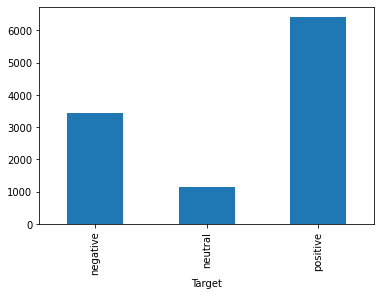

In [10]:
data_train.groupby('Target').size().plot(kind='bar')

<AxesSubplot:ylabel='None'>

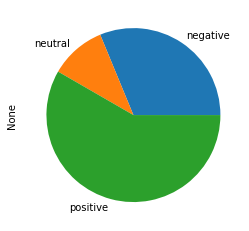

In [43]:
data_train.groupby('Target').size().plot(kind='pie')

(array([27., 11., 37., 58., 41., 45., 53., 46., 30., 59., 67., 53., 58.,
        47., 49., 39., 32., 25., 33., 40., 28., 21., 18., 21., 22., 17.,
        18., 21., 21., 12., 16., 17., 19., 20., 30., 28., 29., 23., 10.,
        11.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  4.,  15.,  26.,  37.,  48.,  59.,  70.,  81.,  92., 103., 114.,
        125., 136., 147., 158., 169., 180., 191., 202., 213., 224., 235.,
        246., 257., 268., 279., 290., 301., 312., 323., 334., 345., 356.,
        367., 378., 389., 400., 411., 422., 433., 444., 455., 466., 477.,
        488., 499., 510., 521., 532., 543., 554.]),
 <BarContainer object of 50 artists>)

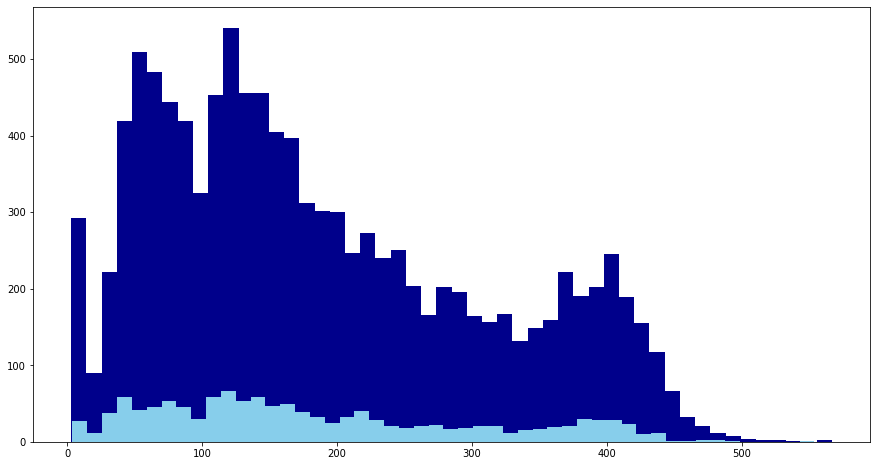

In [11]:
# Melihat panjang teks dalam data train dan data test
 
length_train = data_train['Teks'].str.len()
length_test = data_test['Teks'].str.len()
plt.figure(figsize=(15,8))
plt.hist(length_train, bins=50, label="Train_Teks", color = "darkblue")
plt.hist(length_test, bins=50, label='Test_Teks', color = "skyblue")

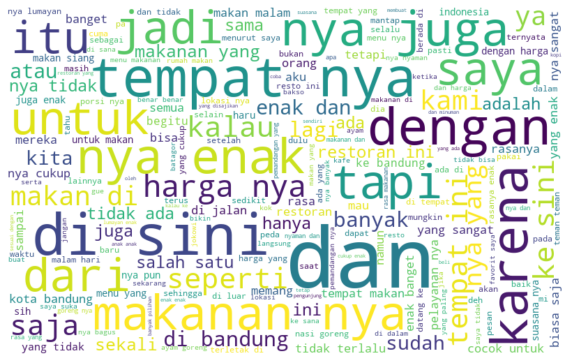

In [12]:
# Sentimen yang ada pada seluruh data train dapat dilihat dengan memahami kata yang umum dengan plot word cloud
 
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
 
all_words = ' '.join([text for text in data_train['Teks']])
wordCloud(all_words)

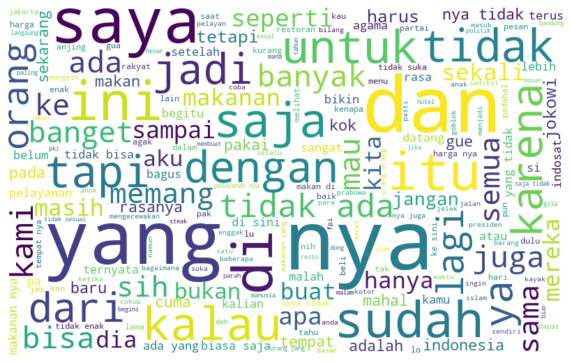

In [13]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'negative']) 
wordCloud(negative_words)

# Preprocessing

pada tahap ini kita akan melakukan vektorisasi dengan TFIDF dari Scikit-learn. Tidak hanya merubahnya menjadi vektor, data text otomatis akan di tokenisasi kan. 

In [14]:
# Melakukan vektorisasi untuk mengekstrak fitur dengan TF-IDF
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
 
train_vectors = vectorizer.fit_transform(data_train['Teks'])
test_vectors = vectorizer.transform(data_test['Teks'])

In [15]:
print(train_vectors)

  (0, 858)	0.07637049523741272
  (0, 237)	0.15109787697218033
  (0, 894)	0.060936546094434454
  (0, 1651)	0.15421430944783843
  (0, 3936)	0.05691989644819672
  (0, 2673)	0.041674425723943795
  (0, 2085)	0.2145440146925309
  (0, 1558)	0.11738430560139437
  (0, 3883)	0.11664723580859972
  (0, 827)	0.08532723440535711
  (0, 1389)	0.07377379261655719
  (0, 1482)	0.11317779622907188
  (0, 3460)	0.14471694731136528
  (0, 3486)	0.14557054051474394
  (0, 263)	0.10386832212863897
  (0, 3509)	0.09908165684043081
  (0, 2007)	0.11236167404789696
  (0, 4051)	0.14736506500322966
  (0, 1079)	0.13455469920124125
  (0, 432)	0.20923444978986025
  (0, 4079)	0.14954101061928382
  (0, 2450)	0.13828741176244957
  (0, 2461)	0.1410007189183509
  (0, 1536)	0.20481434997043935
  (0, 2274)	0.19341622406726763
  :	:
  (10999, 2158)	0.07305954902515958
  (10999, 3317)	0.18676062470497026
  (10999, 345)	0.08570769369706024
  (10999, 3526)	0.14224898903713865
  (10999, 328)	0.08900142005954341
  (10999, 1717)	0.1293

In [16]:
print(test_vectors)

  (0, 4064)	0.39116095517942684
  (0, 3949)	0.318775518059854
  (0, 3683)	0.14766193471723577
  (0, 3461)	0.3075827005632948
  (0, 3125)	0.27512049015602874
  (0, 2509)	0.2919469889165151
  (0, 2211)	0.275737188836178
  (0, 1669)	0.36769190870792534
  (0, 1350)	0.2587949428368911
  (0, 1155)	0.37794387362894916
  (0, 661)	0.21678342198902092
  (1, 3936)	0.6751760660425974
  (1, 1163)	0.7376566137731309
  (2, 4171)	0.05033247018965522
  (2, 4088)	0.16919114724584863
  (2, 3814)	0.18582357001453578
  (2, 3789)	0.21649343928474968
  (2, 3742)	0.12686266258286696
  (2, 3708)	0.12513808104979607
  (2, 3360)	0.16757218343009656
  (2, 3228)	0.0990019251396018
  (2, 3171)	0.09555345172789129
  (2, 3141)	0.1759068835940129
  (2, 2622)	0.23776035864482647
  (2, 2591)	0.1237176047171073
  :	:
  (1259, 4171)	0.18419729924449205
  (1259, 3813)	0.10828351453930445
  (1259, 3694)	0.16575800262874343
  (1259, 3358)	0.182310948894555
  (1259, 3228)	0.1518289672400413
  (1259, 3171)	0.14654040183167721


# Modeling

Pada Modeling kita akan mencoba menggunakan 2 algoritma Machine Learning yaitu, `Random Forest` dan `SVM`. Kita akan membandingkan dari kedua algoritma tersebut mana yang memiliki akurasi yang tinggi untuk kasus kita kali ini.

## Random Forest

In [17]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(train_vectors, data_train['Target'])
predections = rfc.predict(test_vectors)

In [18]:
# print metriks
target_names = ['positive', 'negative', 'netral']
print(classification_report(data_test['Target'], predections, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.77      0.79      0.78       394
    negative       0.79      0.54      0.64       131
      netral       0.89      0.94      0.91       735

    accuracy                           0.85      1260
   macro avg       0.82      0.75      0.78      1260
weighted avg       0.85      0.85      0.84      1260



## SVM

In [19]:
classifier = svm.SVC(kernel='linear')
classifier.fit(train_vectors, data_train['Target'])
predections_2 = classifier.predict(test_vectors)

In [20]:
# print metriks
target_names_2 = ['positive', 'negative', 'netral']
print(classification_report(data_test['Target'], predections_2, target_names=target_names_2))

              precision    recall  f1-score   support

    positive       0.81      0.86      0.84       394
    negative       0.79      0.70      0.74       131
      netral       0.92      0.91      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.87      0.87      0.87      1260



Setelah selesai melakukan Training model dengan dua algoritma, kita bisa melihat bahwa SVM memiliki akurasi yang lebih baik, bahkan nilai dari svm lebih konsisten ketimbang Random Forest. Oleh karena itu kita akan menggunakan model dari SVM untuk uji coba.

# Save Model

Sebelum uji coba, sebelumnya mari kita save modelnya menggunakan `joblib`. Maka akan muncul file baru bernama `model.joblib` tergantung kita menamai file tersebut seperti apa.

In [21]:
# save
joblib.dump(classifier, "./model.joblib")

['./model.joblib']

# Load Model

Setelah model di save, kita harus melakukan load untuk menggunakan model tersebut.

In [22]:
# load, no need to initialize the loaded_rf
model = joblib.load("./model.joblib")

In [42]:
# Testing Model
teks = """Kamu tidak bagus sama sekali"""
teks_vector = vectorizer.transform([teks]) # vectorizing
print(model.predict(teks_vector))

['negative']


Saya memasukan kata `Kamu tidak bagus sama sekali` maka keluar output `negative`. Ternyata model kita berjalan dengan sangat baik, kalian bisa mencoba kata-kata apa saja, sesuka hati kalian. Selamat Mencoba!